In [217]:
from dataclasses import dataclass
from datetime import timedelta, datetime
import asyncio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
from dacite import from_dict

%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('modules')) # or the path to your source code
sys.path.insert(0, module_path)

from metrics import AverageDiffMetric, AdaptingSpeedMetric
from records_replica import UtilizationRecord

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(13333, 4)
13333


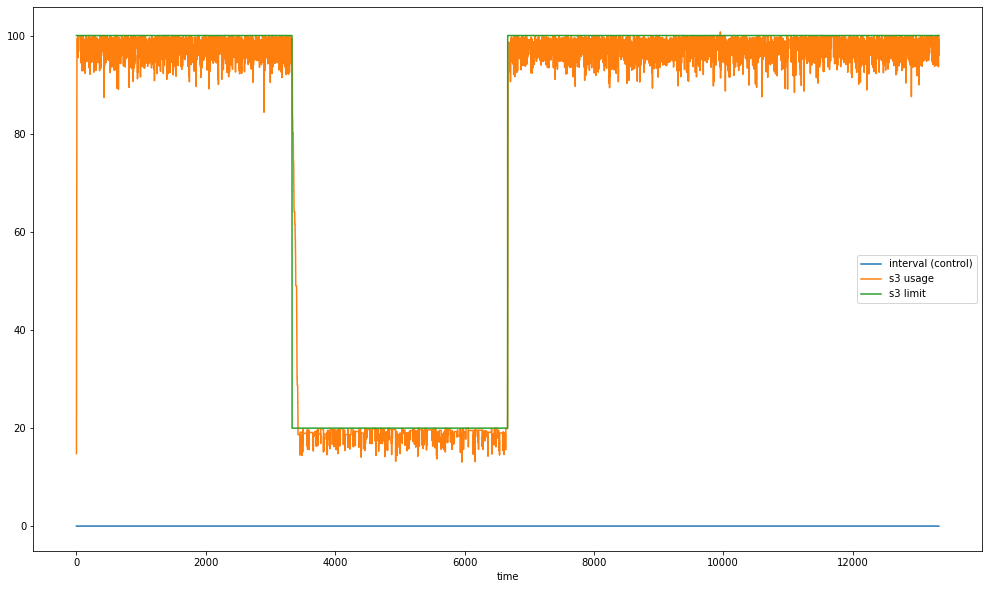

In [34]:
data = pd.read_csv('../pid_interval_control_log.csv')

fig, ax = plt.subplots(figsize=(17, 10))
print(data.shape)
times = np.arange(data.shape[0])
print(len(times))
ax.plot(times, data['interval'], label='interval (control)')
ax.plot(times, data['s3_usage'], label='s3 usage')
ax.plot(times, data['s3_limit'], label='s3 limit')
ax.legend()
ax.set_xlabel('time')
plt.show()


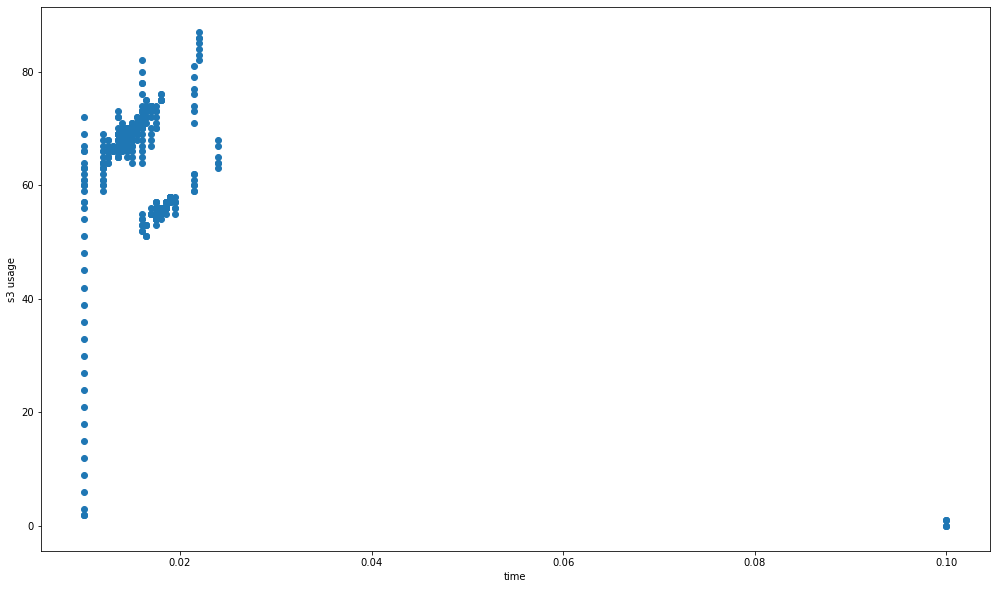

In [22]:
data = pd.read_csv('../pid_interval_control_log.csv')

fig, ax = plt.subplots(figsize=(17, 10))
times = np.arange(data.shape[0])
ax.scatter(data['interval'], data['s3_usage'])
ax.set_xlabel('interval')
ax.set_ylabel('s3 usage')
ax.set_xlabel('time')
plt.show()

(1000, 4)
1000


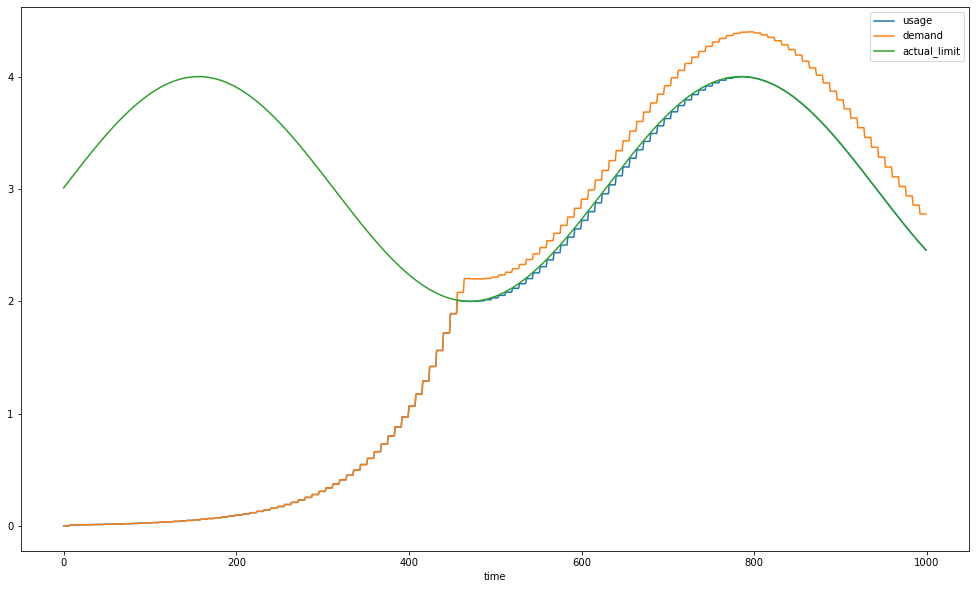

In [43]:
data = pd.read_csv('../soft_limit_main/soft_limit_control_log.csv')

fig, ax = plt.subplots(figsize=(17, 10))
print(data.shape)
times = np.arange(data.shape[0])
print(len(times))
ax.plot(times, data['usage'], label='usage')
ax.plot(times, data['demand'], label='demand')
ax.plot(times, data['actual_limit'], label='actual_limit')
ax.legend()
ax.set_xlabel('time')
plt.show()

(1000, 4)
400


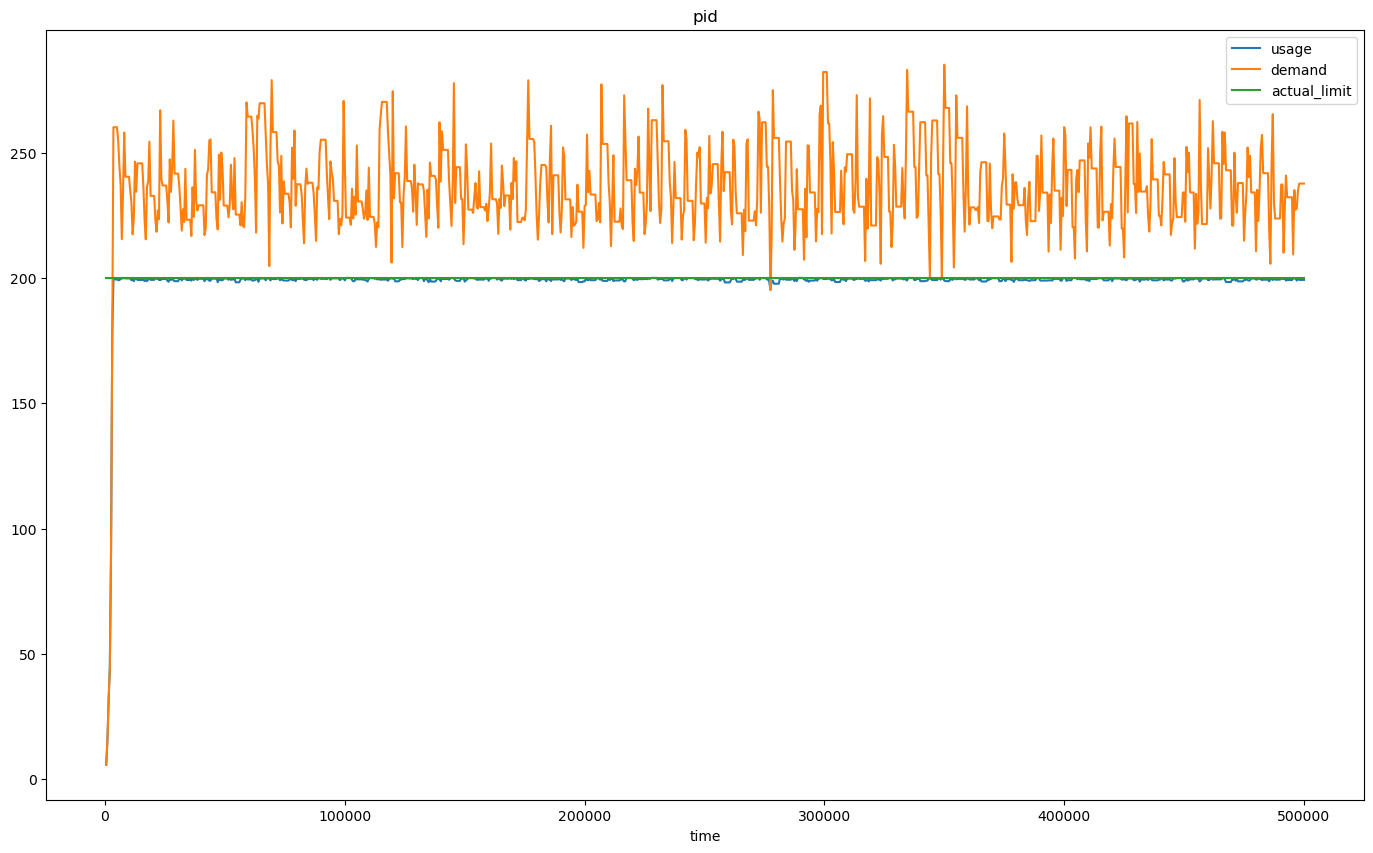

AverageDiffMetric(average_usage_util=0.9927875869892208, average_demand_util=1.1807188896673808, sum_of_deltas=0.18793130267816005, demand_dev=20.66209369677103)
None


In [256]:
def plot(name, file, need_demand_average=False):
    data = pd.read_json(file, lines=True)
    # data = data[data['time'] > 256*60]

    fig, ax = plt.subplots(figsize=(17, 10))
    print(data.shape)
    ax.plot(data['time'], data['usage'], label='usage')
    ax.plot(data['time'], data['demand'], label='demand')
    ax.plot(data['time'], data['actual_limit'], label='actual_limit')
    if need_demand_average:
        ax.axhline(y=data['demand'].mean(), label=f'demand average={round(data["demand"].mean(), 2)}', color='red', linestyle='--')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_title(name)
    plt.show()

    records = [from_dict(data_class=UtilizationRecord, data=d) for d in data.to_dict('records')]
    metrics = AverageDiffMetric.calculate(records)
    print(metrics)
    ramp_metrics = AdaptingSpeedMetric.calculate(records)
    print(ramp_metrics)
    
plot('pid', '../soft_limit_with_tasks/constant_pid.json')

(1000, 4)
400


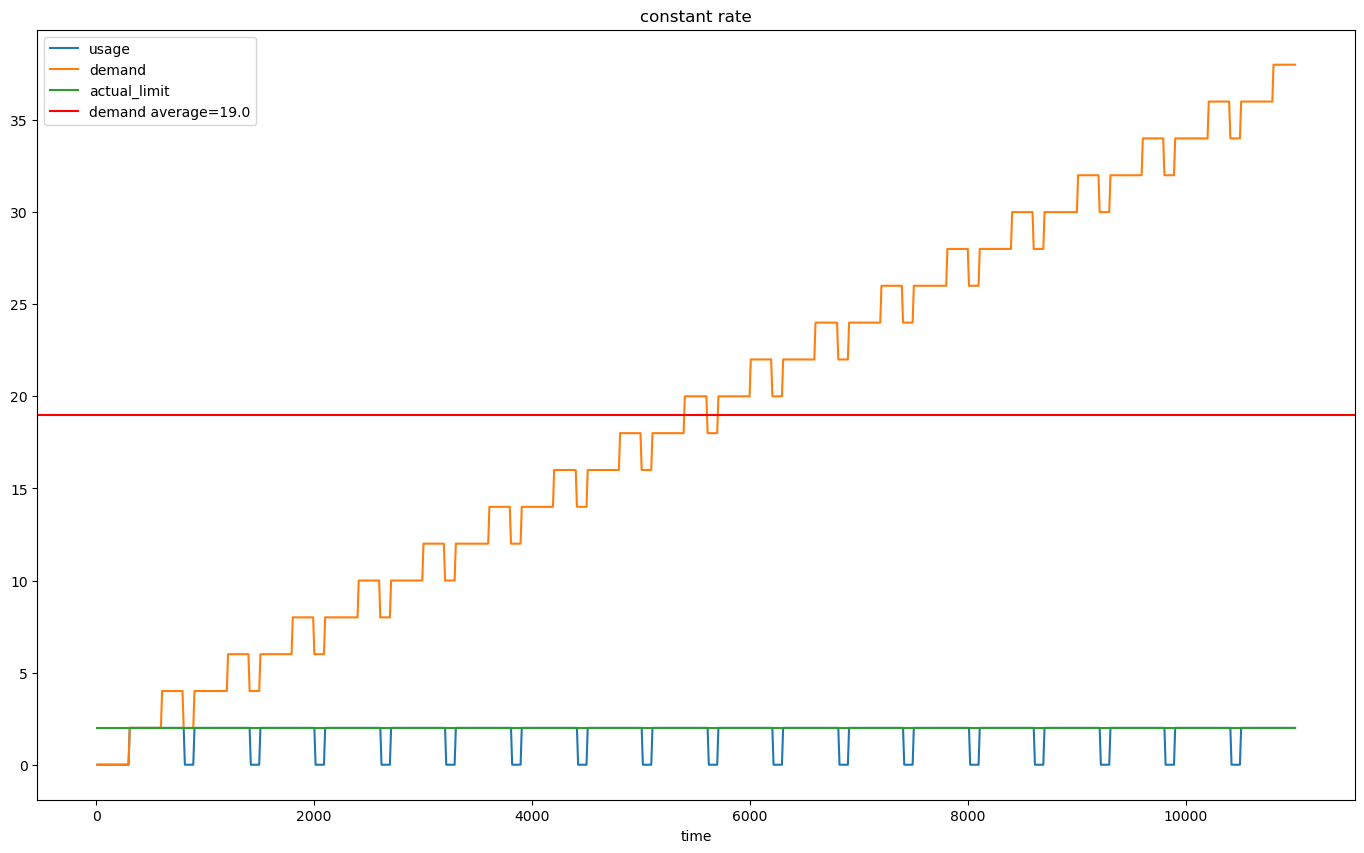

AverageDiffMetric(average_usage_util=0.837, average_demand_util=9.502, sum_of_deltas=8.665000000000001, demand_dev=10.690181663564005)
None


In [251]:
plot('constant rate', '../soft_limit_with_tasks/constant_constant.json')

(970, 4)
400


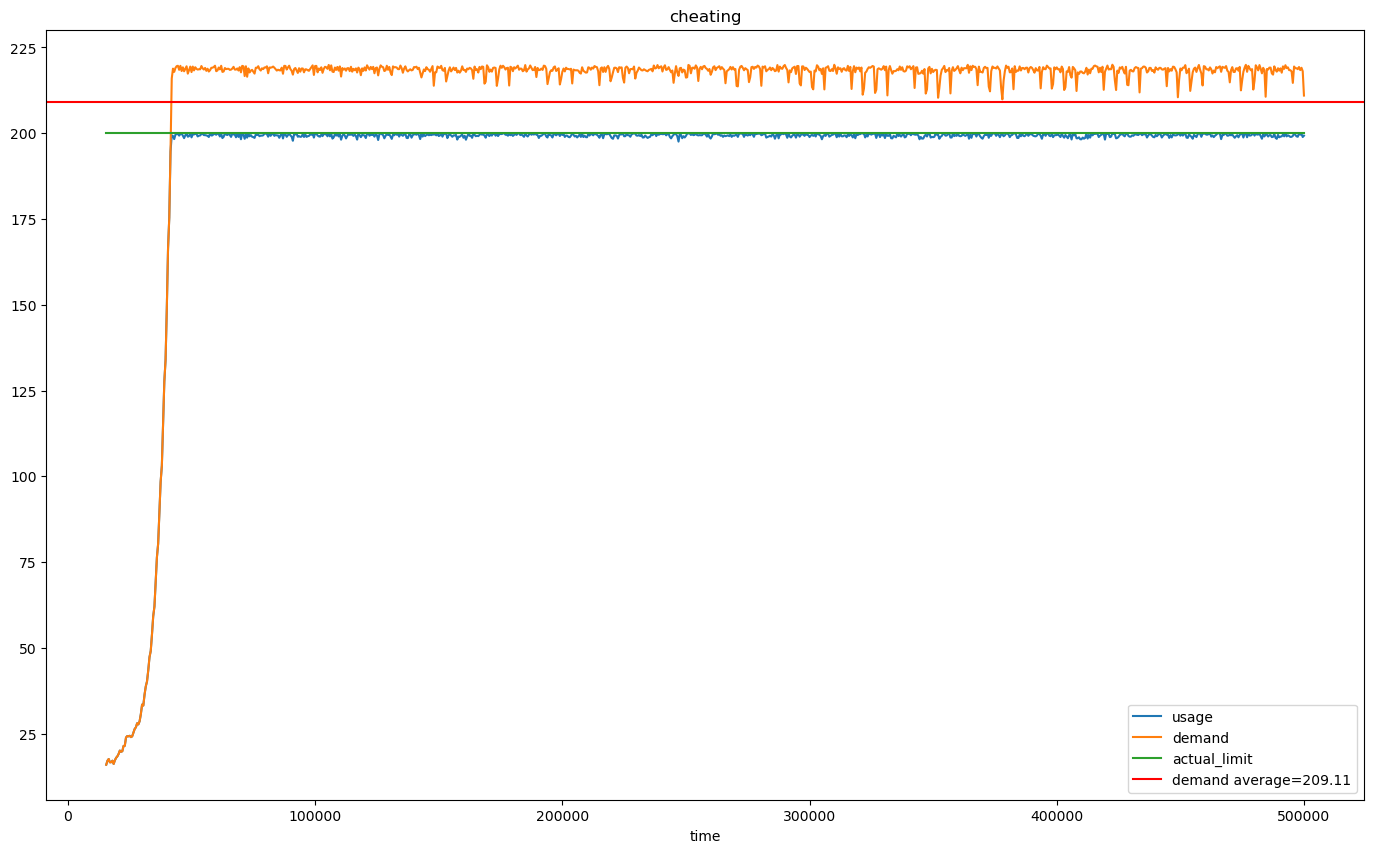

AverageDiffMetric(average_usage_util=0.9563969798964402, average_demand_util=1.0455519524925447, sum_of_deltas=0.0891549725961045, demand_dev=39.4999357642129)
None


In [227]:
plot('cheating', '../soft_limit_with_tasks/constant_cheating.json')

(1000, 4)
400


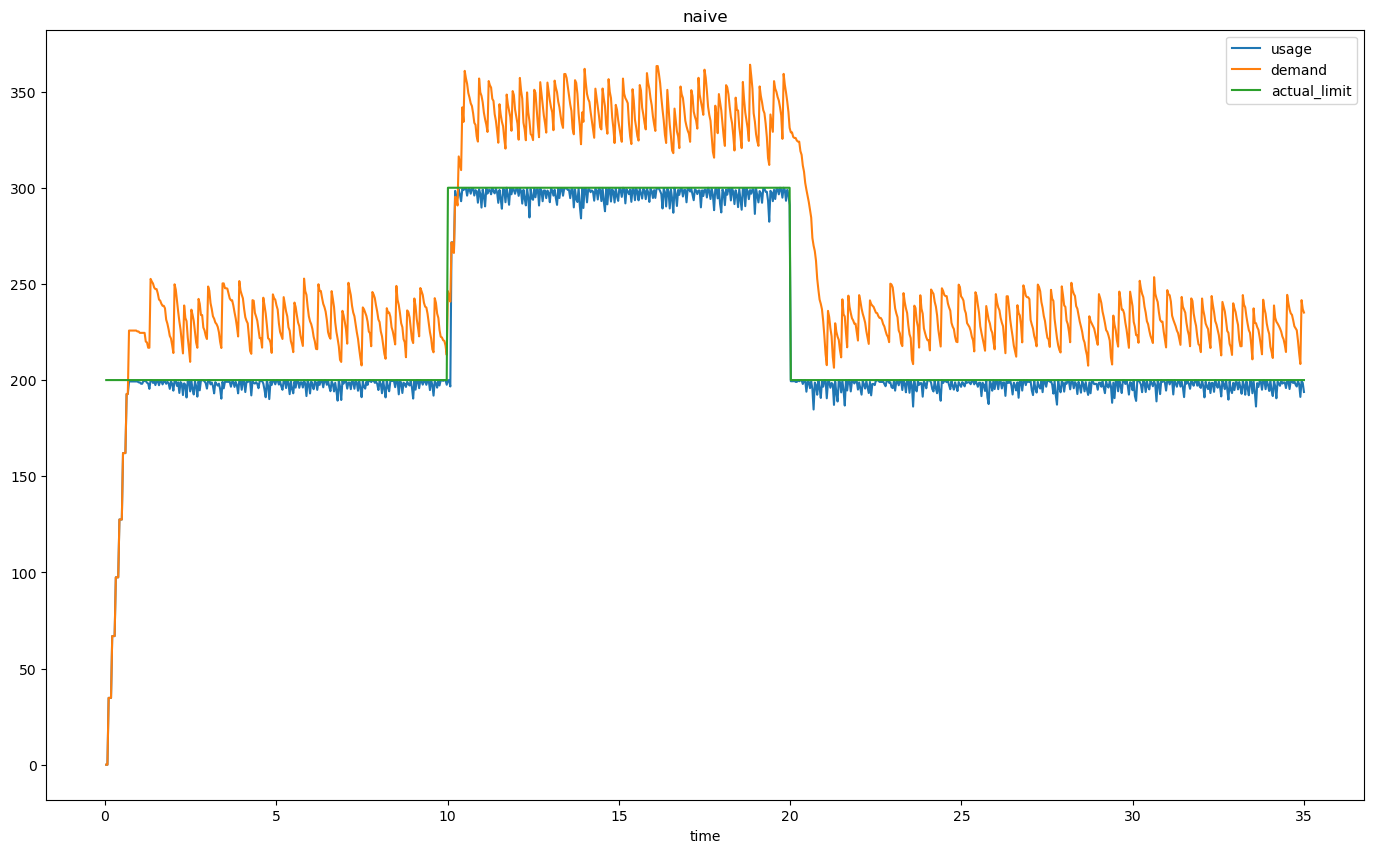

AverageDiffMetric(average_usage_util=0.9767088384787268, average_demand_util=1.1405327787911668, sum_of_deltas=0.16382394031243996)
AdaptingSpeedMetric(time_to_ascend=0.3149999999999995, time_to_descend=1.0500000000000007, sum_of_times=1.3650000000000002)


In [117]:
plot('naive', '../soft_limit_with_tasks/soft_limit_naive.json')

(1000, 4)
400


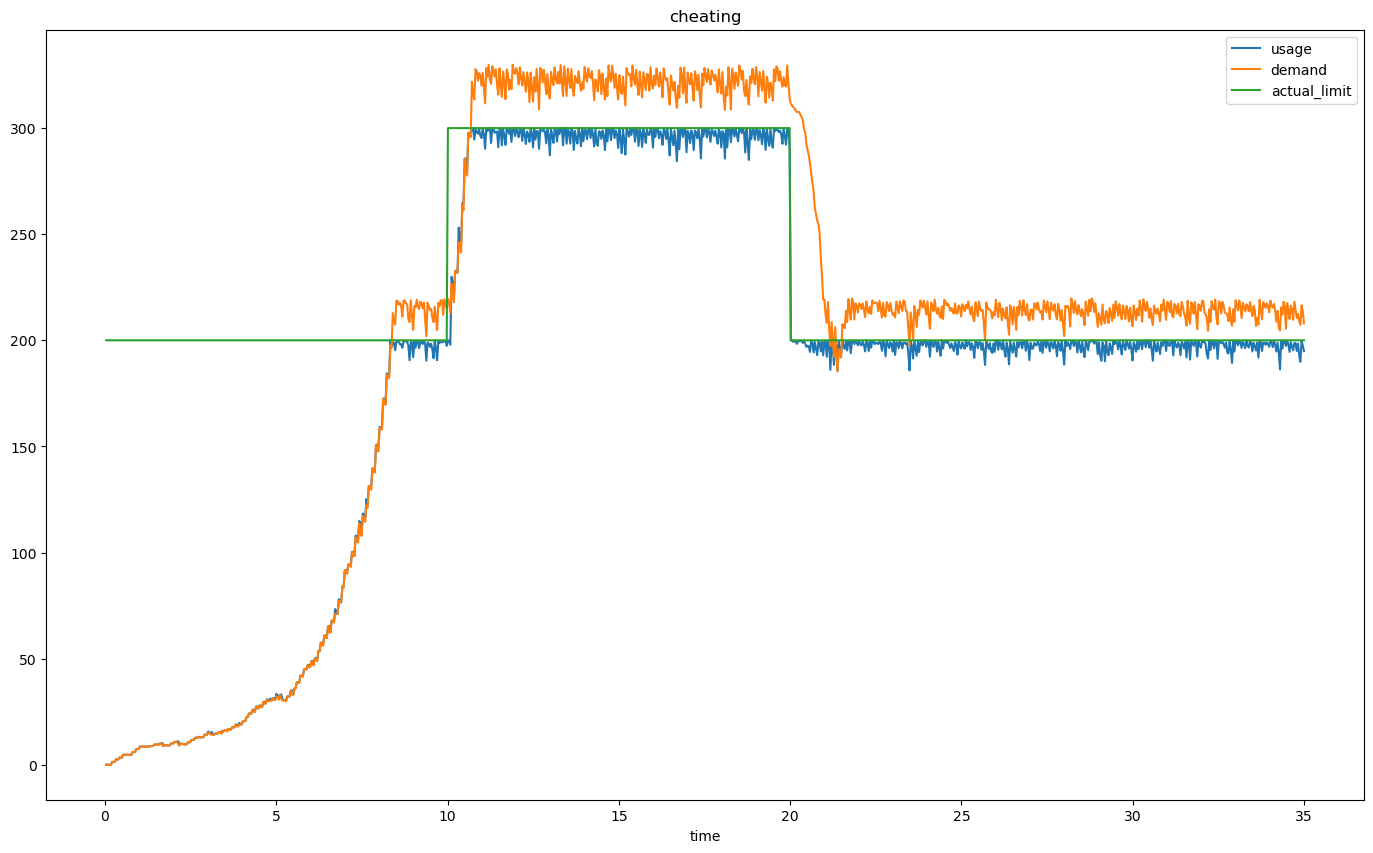

AverageDiffMetric(average_usage_util=0.798803793858051, average_demand_util=0.8687203411027069, sum_of_deltas=0.3324758650392421)
AdaptingSpeedMetric(time_to_ascend=0.7000000000000011, time_to_descend=0.9450000000000003, sum_of_times=1.6450000000000014)


In [110]:
plot('cheating', '../soft_limit_with_tasks/soft_limit_cheating.json')

(999, 4)
400


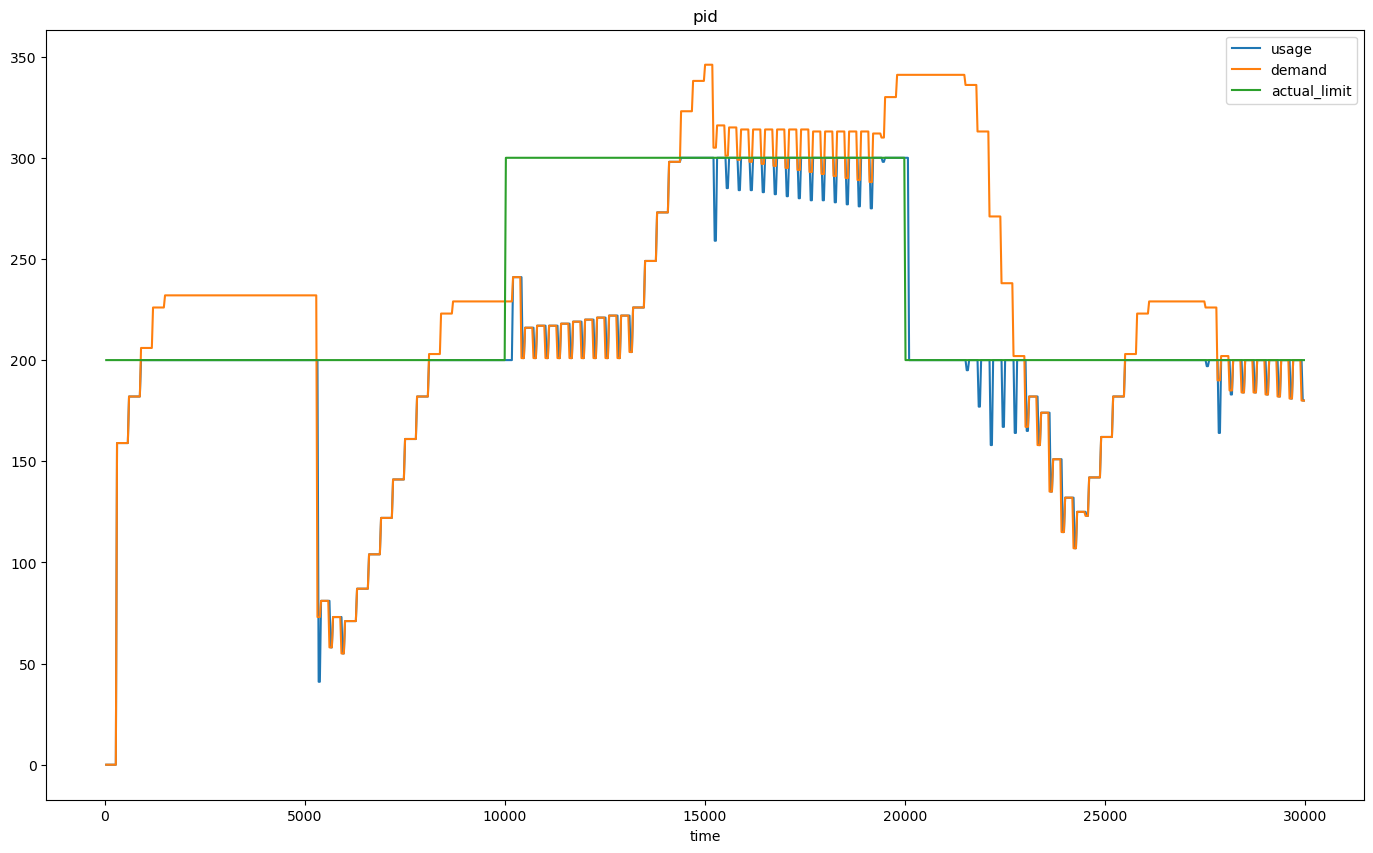

AverageDiffMetric(average_usage_util=0.8897197197197204, average_demand_util=0.9912429095762426, sum_of_deltas=0.11903737070403697, demand_dev=70.52971992247888)
AdaptingSpeedMetric(time_to_ascend=4380, time_to_descend=3000, sum_of_times=7380)


In [291]:
plot('pid', '../soft_limit_with_tasks/pid_stair.json')

In [271]:
# 32 зануляет деманд
# 64: sum_of_deltas=0.20
# 42 зануляет деманд
# 53: sum_of_deltas=0.21
# 80: sum_of_deltas=0.21
# 62: 0.202
# 71: 0.216